In [1]:
import os
import pandas as pd
import numpy as np

# Getting the data ready

In [2]:
# LLM Dataset
data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
data = data[["text", "generated"]].copy()

## Adding more data from Custom Datasets

In [3]:
temp1 = pd.read_csv('/kaggle/input/daigt-external-train-dataset/train_external_drcat_02.csv')
temp1 = temp1[["text", "label"]].copy()
temp1.rename(columns={"label": "generated"}, inplace=True)
temp1.dropna(inplace=True)

/tmp/ipykernel_42/3124174556.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv('/kaggle/input/daigt-external-train-dataset/train_external_drcat_02.csv')


In [4]:
t1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
t2 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
t3 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
t4 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

temp2 = pd.concat([t1, t2, t3, t4], ignore_index=True)
temp2 = temp2[["text", "label"]].copy()
temp2.rename(columns={"label": "generated"}, inplace=True)
temp2.dropna(inplace=True)

In [5]:
t1 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
t2 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

temp3 = pd.concat([t1, t2], ignore_index=True)
temp3 = temp3[["text", "label"]].copy()
temp3.rename(columns={"label": "generated"}, inplace=True)
temp3.dropna(inplace=True)

## Remove Duplicate Rows

In [6]:
data = pd.concat([data, temp1, temp2, temp3], ignore_index=True)
data.drop_duplicates(inplace=True,ignore_index=True)

In [7]:
data["generated"].value_counts()

generated
1.0    57356
0.0    32428
Name: count, dtype: int64

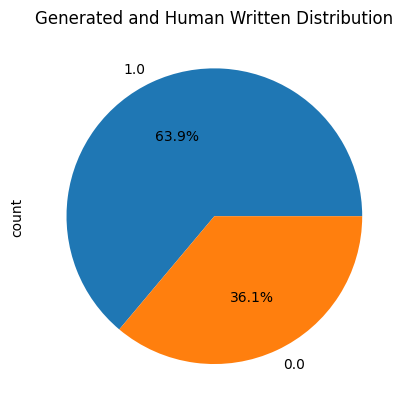

In [8]:
import matplotlib.pyplot as plt
data['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Generated and Human Written Distribution")
plt.show()

### Balancing the Data

In [9]:
data_human = data[data["generated"]==0]
data_human.shape

(32428, 2)

In [10]:
data_ai = data[data["generated"]==1]
data_ai.shape

(57356, 2)

In [11]:
data_ai = data_ai.sample(data_human.shape[0])
data_ai.shape

(32428, 2)

In [12]:
data = pd.concat([data_human, data_ai])
data.shape

(64856, 2)

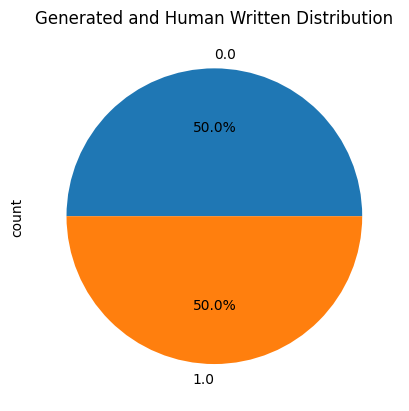

In [13]:
import matplotlib.pyplot as plt
data['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Generated and Human Written Distribution")
plt.show()

# Building the Model

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data.text, data.generated, test_size=0.1, shuffle=True)

### Bert Model

In [16]:
model_path ="/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2"
preprocess_path = "/kaggle/input/bert/tensorflow2/en-cased-preprocess/3"

In [17]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocess_path)
encoder_inputs  = preprocessor(text_input)

In [18]:
encoder = hub.KerasLayer(model_path,trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output'] 
sequence_output = outputs["sequence_output"]

In [19]:
dropout = tf.keras.layers.Dropout(0.51 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.3 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)

model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.hdf5'
metric = 'val_accuracy'
callback_list = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=metric,
                    verbose=2, save_best_only=True, mode='max')
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],epochs=1 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")

7297/7297 [==============================] - 1954s 262ms/step - loss: 0.3257 - acc: 0.8565 - val_loss: 0.1734 - val_acc: 0.9354


In [21]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

1825/1825 [==============================] - 647s 354ms/step - loss: 0.1635 - acc: 0.9386
Accuracy on Train data: 0.9385643601417542
203/203 [==============================] - 70s 347ms/step - loss: 0.1734 - acc: 0.9354
Accuracy on Test data: 0.9353992938995361


In [23]:
y_pred_prob = model.predict(x_test)
y_pred_prob = y_pred_prob[:, 0]

203/203 [==============================] - 67s 331ms/step


In [25]:
y_pred = np.where(y_pred_prob <= 0.5, 0, 1)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2961  317]
 [ 102 3106]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      3278
         1.0       0.91      0.97      0.94      3208

    accuracy                           0.94      6486
   macro avg       0.94      0.94      0.94      6486
weighted avg       0.94      0.94      0.94      6486



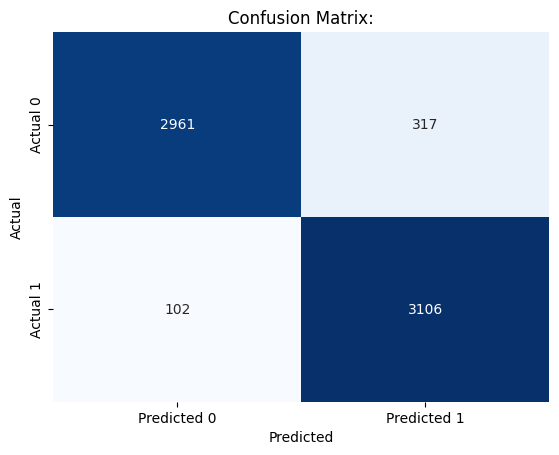

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix:')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_data = test_df[["text"]].copy()

In [32]:
output_data = model.predict(test_data['text'])
output_data = output_data[:, 0]

1/1 [==============================] - 0s 31ms/step


In [33]:
output_df = pd.DataFrame({
    "id": test_df["id"],
    "generated": output_data
})
output_df.to_csv('/kaggle/working/submission.csv')

In [34]:
output_df

,id,generated
0,0000aaaa,0.621316
1,1111bbbb,0.630440
2,2222cccc,0.619920
